In [1]:
include("./PeriodicKdV.jl")
using .PeriodicKdV
using LinearAlgebra, Plots, SparseArrays
ep = 1e-15

1.0e-15

In [2]:
dx = 0.5
L = 5
left = -L:2dx:-2dx |> Array
gapfun = x -> 1.5./(1 .+ x.^2)
sp = 1.0:1.0:length(left) |> Vector
len = dx*gapfun(sp) |> reverse
right = left + len
gaps = - hcat(right |> reverse ,left |> reverse);
gaps

5×2 Array{Float64,2}:
 0.625    1.0
 1.85     2.0
 2.925    3.0
 3.95588  4.0
 4.97115  5.0

In [3]:
r = (x,y) -> (x |> Complex |> sqrt)/(y |> Complex |> sqrt)
pr = (x,y) -> (x |> Complex |> sqrt)*(y |> Complex |> sqrt)
p = (z) -> -1im*prod(map(r,gaps[:,1] .- z, gaps[:,2] .- z))/sqrt(-z |> Complex)
P = (z) -> prod(map(pr, z .- gaps[:,1],  z .- gaps[:,2]))*1im*sqrt(-z |> Complex)

#11 (generic function with 1 method)

In [4]:
P(-10000)

0.0 - 1.0014671577826009e22im

# My first approach

We need to construct the differentials $\omega_j$ such that

$$ \int_{\beta_\ell}^{\alpha_{\ell+1}} \omega_j = i \pi \delta_{\ell,j} $$

In my previous paper, I used the basis of differentials given by

$$\frac{\lambda^{j-1}}{w} d \lambda, \quad j = 1,2,\ldots,g$$

where

$$ w^2 = P(\lambda), \quad P(\lambda) = (\lambda- \alpha_{g+1}) \prod_{j=1}^g (\lambda - \alpha_j)(\lambda- \beta_j).$$

But I'm am almost certain that this is doomed to numerical instabilities for large $g$.  So, we will modify the basis.  Define the polynomials:

$$ q_j(\lambda) = \prod_{\substack{\ell = 1 \\ \ell \neq j}}^g (\lambda - \beta_\ell). $$

And consider the basis

$$ \gamma_j = \frac{q_j(\lambda)}{w} d \lambda, \quad j = 1,2,\ldots,g.$$

Ignoring issues related to the branch for $\sqrt{P(\lambda)}$ we can see that the principal part of the differential can be written as

$$ \frac{-i}{\sqrt{-\lambda + \alpha_1}}\left(\prod_{\substack{\ell = 1 \\ \ell \neq j}}^g \frac{\sqrt{\lambda - \beta_\ell}}{\sqrt{\lambda - \alpha_{\ell+1}}} \right)  \frac{1}{\sqrt{\lambda - \beta_j}\sqrt{\lambda - \alpha_{j+1}}}$$

The branch for $\sqrt{P(\lambda)}$ is chosen so that it is analytic off the intervals $[\alpha_j,\beta_j]$, $[\alpha_{g+1}, \infty)$ and $P(\lambda) \sim (-1)^g i |\lambda|^{g + 1/2}$ as $\lambda \to - \infty, ~\lambda < 0$.  So, we'll check that below.  

## Check correct asymptotics

In [5]:
dx = 0.5
L = 4
left = -L:2dx:-2dx |> Array
gapfun = x -> 1.5./(1 .+ x.^2)
sp = 1.0:1.0:length(left) |> Vector
len = dx*gapfun(sp) |> reverse
right = left + len
gaps = - hcat(right |> reverse ,left |> reverse)
#gaps[1:2,:]

4×2 Array{Float64,2}:
 0.625    1.0
 1.85     2.0
 2.925    3.0
 3.95588  4.0

In [6]:
h = z -> sqrt((z-1)*(z+1) |> compl)

#15 (generic function with 1 method)

In [7]:
# should be a jump
P(.3 + 1im*ep) - P(.3 - 1im*ep) |> display

8.304531506032564 + 0.0im

In [8]:
# should be no jump in the first gap
P(.7 + 1im*ep) - P(.7 - 1im*ep) |> display

9.438822583872593e-15 + 0.0im

In [9]:
# should be no jump in the second gap
P(1.9 + 1im*ep) - P(1.9 - 1im*ep) |> display

-2.2055585869154254e-15 + 0.0im

In [10]:
λ = -50000.0
P(λ) |> display
g = size(gaps)[1]
P(λ)/((-1)^g*1im*abs(λ)^(g + 1/2)) # should tend to one

0.0 + 1.397813010688509e21im

1.0001935717546067 - 0.0im

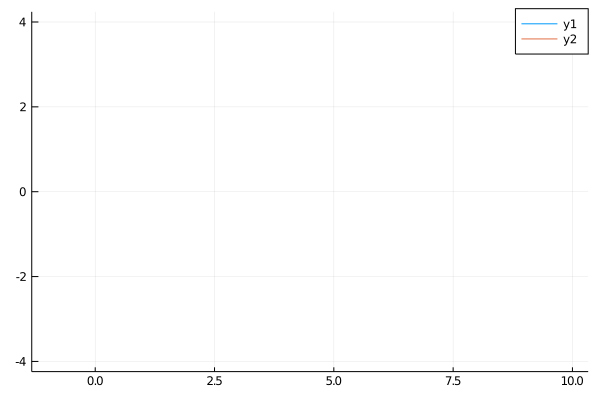

In [11]:
x = -1:.01:10
plot(x, map(p,x .+1im*ep)|> real, yaxis = [-4,4])
plot!(x, map(p,x .+1im*ep )|> imag, yaxis = [-4,4])

In [12]:
p(-10000)

0.0 - 0.009999677995906215im

## Quadrature

Now, we need to understand how to compute integrals of the form

$$
\int_{\beta_k}^{\alpha_{k+1}} \frac{q_j(\lambda)}{\sqrt{P(\lambda)}} d \lambda.
$$

If $k = j$ then we write this as

$$
\int_{\beta_j}^{\alpha_{j+1}} f_{jk}(\lambda)   \frac{d \lambda}{\pi \sqrt{\lambda - \beta_j}\sqrt{\alpha_{j+1}-\lambda}}
$$

and expand $f_{jk}$ in a (shifted and scaled) Chebyshev $T$ series.

If $k \neq j$ then we write this as

$$
\int_{\beta_j}^{\alpha_{j+1}} f_{jk}(\lambda) \frac{\sqrt{\lambda - \beta_j}}{\pi \sqrt{\lambda - \alpha_{j+1}}} \frac{2}{\alpha_{j+1}- \beta_j} d \lambda
$$

and expand $f_{jk}$ in a (shifted and scaled) Chebyshev $V$ series.

To understand how these have been normalized, we need to develop general quadrature routines via an affine transformation $M$.

We know that if we compute $f(x) \approx \sum_{j=0}^n c_j p_j(x)$ for normalized OPs $\{p_j\}$ on $[-1,1]$ with (probability) weight $\rho(x)$ then


$$ \int_{-1}^1 f(s) \rho(s) ds \approx c_0.$$


So, for $f$ defined on a general interval $[a,b]$, we wish to compute

$$ I_{(a,b)}(f;\rho) = \frac{2}{b-a}\int_{a}^b f(x) \rho(M^{-1}(x)) dx, \quad M: [-1,1] \to [a,b].$$ 

Note that

$$ \int_a^b \frac{2}{b-a}\rho(M^{-1}(x)) dx = 1.$$

Set $M(s) = x$ to find

$$I_{(a,b)}(f;\rho) = \int_{-1}^1 f(M(s)) \rho(s) d s \approx c_0 $$

where $f(M(s)) \approx \sum_{j=0}^n c_j p_j(s)$.

We then should consider what this looks like for specific weights:

1. $\rho(x) = \frac{1}{\pi} \sqrt{\frac{1 + x}{1-x}}$ $\longrightarrow$ $\rho(M^{-1}(x)) = \frac{1}{\pi} \sqrt{\frac{x-a}{b-x}}$
1. $\rho(x) = \frac{1}{\pi} \sqrt{\frac{1 - x}{1+x}}$ $\longrightarrow$ $\rho(M^{-1}(x)) = \frac{1}{\pi} \sqrt{\frac{b-x}{x-a}}$
1. $\rho(x) = \frac{1}{\pi} \frac{1}{\sqrt{1-x^2}}$ $\longrightarrow$ $\rho(M^{-1}(x)) = \frac{1}{\pi} \frac{1}{\sqrt{(b-x)(x-a)}} \frac{b-a}{2}$
1. $\rho(x) = \frac{2}{\pi} \sqrt{1-x^2}$ $\longrightarrow$ $\rho(M^{-1}(x)) = \frac{2}{\pi} \frac{2}{b-a}\sqrt{(b-x)(x-a)}$

$$I_{(a,b)}(f;\rho_T)$$

In [13]:
a, b = 0.0, 4.0
integrateT = DefiniteIntegral(transformT,a,b,100)
f = x -> exp(x + 1im*x)
integrateT*f |> display
mathematica = (-12.044554079130346 - 5.287557538079984*1im)

-12.044554280282194 - 5.287557764246001im

-12.044554079130346 - 5.287557538079984im

$$I_{(a,b)}(f;\rho_V)$$

In [14]:
a, b = 0.0, 4.0
integrateV = DefiniteIntegral(transformV,a,b,100)
f = x -> exp(x + 1im*x)
integrateV*f |> display
mathematica = (-44.14160811860679 - 24.182806914046154*1im)/2

-22.07080446160706 - 12.091403909137618im

-22.070804059303395 - 12.091403457023077im

In [15]:
a, b = 0.0, 4.0
integrateU = DefiniteIntegral(transformU,a,b,100)
f = x -> exp(x + 1im*x)
integrateU*f |> display
mathematica = (-16.830096326216506 + 3.222404036433258*1im)/2

-8.415048163108244 + 1.611202018216626im

-8.415048163108253 + 1.611202018216629im

## Constructing $f_{jk}$

We construct a `gaps` array where the first column is $\beta_1,\beta_2,\ldots$ and the second column is $\alpha_2,\alpha_3,\ldots$ because we have assume, for simplicity that $\alpha_1 = 0$.  

In [257]:
dx = 0.5
L = 5
left = -L:2dx:-2dx |> Array
gapfun = x -> 1.5./(1 .+ x.^2)
sp = 1.0:1.0:length(left) |> Vector
len = dx*gapfun(sp) |> reverse
right = left + len
gaps = - hcat(right |> reverse ,left |> reverse);
bands = copy(gaps)
bands[:,2] = gaps[:,1]
bands[2:end,1] = gaps[1:end-1,2]
bands[1,1] = 0.0
g = size(gaps)[1]
σ = [.2,.3,.4,.5,.6]
zs = σ.*gaps[:,1] + (1.0 .- σ).*gaps[:,2]
zs |> display
gaps |> display

5-element Array{Float64,1}:
 0.925
 1.955
 2.9699999999999998
 3.9779411764705883
 4.982692307692307

5×2 Array{Float64,2}:
 0.625    1.0
 1.85     2.0
 2.925    3.0
 3.95588  4.0
 4.97115  5.0

In [208]:
r = (x,y) -> (x |> Complex |> sqrt)/(y |> Complex |> sqrt)
pr = (x,y) -> (x |> Complex |> sqrt)*(y |> Complex |> sqrt)
p = (z) -> -1im*prod(map(r,gaps[:,1] .- z, gaps[:,2] .- z))/sqrt(-z |> Complex)
P = (z) -> prod(map(pr, z .- gaps[:,1],  z .- gaps[:,2]))*1im*sqrt(-z |> Complex)

#643 (generic function with 1 method)

In [209]:
function F(j,k,z)
    out = -1im/sqrt(-z |> Complex)
    for i = 1:size(gaps)[1]
        if i != j && i != k
            out *= r(z - gaps[i,1], z - gaps[i,2])
        end
    end
    if j == k
        return -out*pi*1im
    else
        return -1im*(gaps[k,2]-gaps[k,1])/2*out/pr(z - gaps[j,1], z - gaps[j,2])*pi
    end
end
    

function G(j,k,z)
    out = -1im/sqrt(gaps[end,end]-z |> Complex)
    for i = 1:size(bands)[1]
        if i != j && i != k
            out *= r(z - bands[i,2], z - bands[i,1])
        end
    end
    if j == k
        return -out*pi*1im
    else
        return 1im*(bands[k,2]-bands[k,1])/2*out/pr(z - bands[j,1], z - bands[j,2])*pi
    end
end

G (generic function with 1 method)

In [210]:
F(1,2,-1)

0.1285844014602412 + 0.0im

In [211]:
DefiniteIntegral(transformT,gaps[3,2],gaps[3,1],50)*(z -> F(3,3,z+1im*ep))

-6.344182817589021e-16 - 2.08090241914658im

Row `i` of the matrix `A` below gives the integrals of differential `i` over all the gaps.

In [212]:
g = size(gaps)[1]
A = zeros(Complex{Float64},g,g);
for i = 1:g
    for j = 1:g
        if i == j
            A[i,i] = -2*(DefiniteIntegral(transformT,gaps[i,1],gaps[i,2],50)*(z -> F(i,i,z+1im*ep)))
        else
            A[j,i] = -2*(DefiniteIntegral(transformV,gaps[i,1],gaps[i,2],50)*(z -> F(j,i,z+1im*ep)))
        end
    end
end

tB = zeros(Complex{Float64},g,g);
for i = 1:g
    for j = 1:g
        if i == j
            tB[i,i] = 2*(DefiniteIntegral(transformT,bands[i,1],bands[i,2],50)*(z -> G(i,i,z+1im*ep)))
        else
            tB[j,i] = 2*(DefiniteIntegral(transformW,bands[i,1],bands[i,2],50)*(z -> G(j,i,z+1im*ep)))
        end
    end
end

B = copy(tB)
B[:,1] = tB[:,1]
for j = 2:g
   B[:,j] = B[:,j] + B[:,j-1]
end

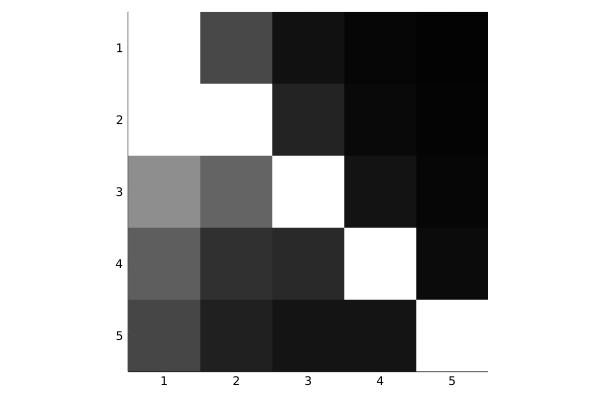

In [213]:
A |> PeriodicKdV.spy

In [214]:
A

5×5 Array{Complex{Float64},2}:
  4.57968e-15+6.40016im   3.36656e-16+0.281577im  …  3.91997e-18+0.0103606im
  5.11643e-16-1.19222im   2.34416e-15+5.10259im      6.73292e-18+0.014399im
 -8.32189e-17-0.555112im  2.33018e-16-0.391094im     1.38537e-17+0.0218849im
 -1.17138e-16-0.367389im  1.05873e-17-0.18869im      4.86162e-17+0.0436444im
 -1.10597e-16-0.275648im  -1.4177e-17-0.125005im     4.71139e-16+3.14091im

In [215]:
C = hcat(A,B)
C = 2im*pi*(A\C)
eigvals(real(C[:,g+1:end]))

5-element Array{Float64,1}:
 -27.720633679160713
 -11.432653187378529
  -9.007619030897464
  -7.4383134422562724
  -5.256478485924843

In [216]:
C[:,g+1:end]

5×5 Array{Complex{Float64},2}:
 -7.05547-1.08457e-14im  -3.07791-1.00799e-14im  …  -1.69719-4.18469e-15im
 -3.07791-6.47113e-15im  -10.5786-2.555e-14im       -2.87981-2.31979e-14im
 -2.30777-3.87399e-15im  -4.42029-1.04938e-14im     -4.06776-5.64336e-14im
 -1.93211-2.73921e-15im  -3.40127-6.83342e-15im     -5.73339-1.03614e-13im
 -1.69719-2.11373e-15im  -2.87981-5.18379e-15im     -15.8345-9.70073e-14im

## Abel map

We consider integrating

$$
    \int_{A}^B \frac{q_j(\lambda)}{\sqrt{P(\lambda)}} d\lambda, \quad \beta_\ell \leq A \leq B \leq \alpha_{\ell+1}.
$$

The key to performing such integration is the formula

$$
 \int_{-1}^\lambda T_n(x) \frac{dx}{\sqrt{1 - x^2}} = \begin{cases} - \frac{ \sin (n \arccos \lambda) }{n} & n > 0\\
  \pi - \arccos \lambda & n = 0. \end{cases}
$$

Since we consider the orthonormalized polynomials $\{\tilde T_n\}$ with respect to a probability density, we rewrite this as

$$
   J_n(\lambda) =  \int_{-1}^\lambda \tilde T_n(x) \frac{dx}{\pi \sqrt{1 - x^2}} = \begin{cases} - \frac{\sqrt{2}}{\pi} \frac{ \sin (n \arccos \lambda) }{n} & n > 0\\
  1 - \frac{\arccos \lambda}{\pi} & n = 0. \end{cases}
$$

This gives an obvious formula to compute

$$
 \int_{-1}^\lambda f(x) \frac{dx}{\pi \sqrt{1 - x^2}} 
$$

provided that $f(x) \approx \sum_{j=0}^N c_j \tilde T_j(x)$.

To treat the general case, consider for $a \leq \lambda \leq b$

$$
I^\lambda_{(a,b)}(f) = \int_{a}^\lambda f(x) \frac{dx}{\pi \sqrt{(b-x)(x-a)}}
$$

This integral, after setting $x(s) = \frac{b-a}{2}s + \frac{b+a}{2}$ and $F(s) = f(x(s)) \approx \sum_j c_j T_j(s)$ we find

$$
\int_{-1}^{\frac{2}{b-a} \lambda - \frac{b+a}{b-a} } F(s) \frac{ds}{\pi \sqrt{1 - s^2}}  \approx \sum_j c_j J_n\left( \frac{2}{b-a} \lambda - \frac{b+a}{b-a} \right)
$$

Recall $M: [-1,1] \to [a,b]$.

In [264]:
function J(n,λ)
     if n == 0
        1 - acos(λ)/pi
    else
        - sqrt(2)/pi*sin(n*acos(λ))/n
    end
end

function J(f,a,b,n,λ)
    cs = transformT(map(f,M(a,b)(Ugrid(n))))
    out = 0im
    for i = 1:length(cs)
        out += cs[i]*J(i-1,iM(a,b)(λ))
    end
    out
end


function Abel(n,j,k,λ) # integrate differential k over part of gap j
    a = gaps[j,1] 
    b = gaps[j,2]
    if k == j
        -J(xx -> F(j,k,xx), a, b, n, λ)
    else
        #println(2/(gaps[j,2]-gaps[j,1]))
        -2/(gaps[j,2]-gaps[j,1])*J( xx -> F(k,j,xx)*(xx - gaps[j,1]), a, b, n, λ)
    end
end

function Abel(n,k,λ) # integrate differential k over part of gap j
    j = 1
    for jj = 1:g
        if gaps[j,1] <= λ <= gaps[j,2]
            break
        end
        j += 1
    end
    if j == g + 1
        @error "Not in a gap"
        return 0
    else
        return Abel(n,j,k,λ)
    end
end

Abel (generic function with 2 methods)

In [268]:
# abel = map( k -> Abel(20,k,gaps[1,2]), 1:g) -  map( k -> Abel(20,k,zs[1]), 1:g)
# for j = 2:g
#     abel += map( k -> Abel(20,k,gaps[j,2]), 1:g) - map( k -> Abel(20,k,zs[j]), 1:g)
# end
# abel = (A\abel)*2im*pi
abel =  map( k -> Abel(20,k,zs[1]), 1:g)
for j = 2:g
     abel += map( k -> Abel(20,k,zs[j]), 1:g)
end
abel = (A\abel)*(2im*pi)

5-element Array{Complex{Float64},1}:
 1.6563532706121762e-15 - 2.249871684870116im
 1.6508323436434573e-15 - 2.1767677467234323im
  1.080525725709775e-15 - 1.9723840481102475im
  6.941811324041484e-16 - 1.7567130453487139im
 4.4374079218238497e-16 - 1.5441490039611354im

In [269]:
zgaps_neg = hcat(- sqrt.(gaps[:,2]) |> reverse, - sqrt.(gaps[:,1]) |> reverse)
zgaps_pos = hcat( sqrt.(gaps[:,1]) , sqrt.(gaps[:,2]) )
zzs_pos = sqrt.(zs)
zzs_neg = -sqrt.(zs) |> reverse;

In [280]:
fV = (x,y) -> WeightedInterval(x,y,chebV)
fW = (x,y) -> WeightedInterval(x,y,chebW)

WIm = map(fV,zgaps_neg[:,1],zgaps_neg[:,2])
WIp = map(fW,zgaps_pos[:,1],zgaps_pos[:,2])
Skew = θ -> [0 exp(θ); exp(-θ) 0]

gp = (x,θ) -> Cut(Skew(θ), x)
gm = (x,θ) -> Cut(Skew(-θ), x)  ###????????

#1021 (generic function with 1 method)

Time for generation and compression


5-element Array{Float64,1}:
 3.0606670550547965e-14
 3.6765657020825035e-14
 6.78772326899588e-14
 1.0123406595747183e-13
 2.540521812280924e-13

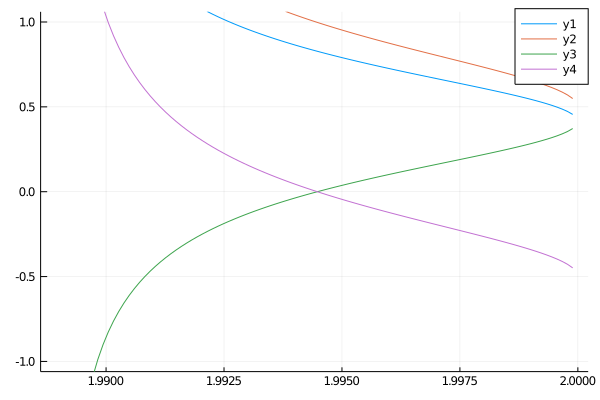

  0.765686 seconds (3.25 M allocations: 260.520 MiB, 5.19% gc time)
Time for operator construction
  0.004258 seconds (2.16 k allocations: 5.578 MiB)
Time to solve
iteration = 2, residual = 0.24990414783054077
iteration = 3, residual = 0.010851036426788654
iteration = 4, residual = 0.00023437639787293922
iteration = 5, residual = 2.622029716130164e-7
iteration = 6, residual = 2.2545987346413442e-10
iteration = 7, residual = 6.045741145065245e-14
  0.089745 seconds (29.87 k allocations: 28.030 MiB, 21.07% gc time)


In [289]:
RHP = vcat(map(gm,WIm,abel |> reverse),map(gp,WIp,abel));
n = 50
k = 4
out = SIE_new(RHP,n,1e-12,100);
Φ = (z,o) -> [Cauchy(out[1],z,o) + 1.0, Cauchy(out[2],z,o) + 1.0] |> transpose
map(x -> abs.(Φ(x,1)) |> minimum, zzs_pos) |> display
len = zgaps_pos[k,2] - zgaps_pos[k,1]
x = zgaps_pos[k,1] + 0.0001*len:0.01*len:zgaps_pos[k,2]-0.0001*len
y = map( z -> Φ(z,1)[1], x)
plot(x, y |> real)
plot!(x, y |> imag)
y = map( z -> Φ(z,1)[2], x)
plot!(x, y |> real)
plot!(x, y |> imag, yaxis = [-1,1]) |> display

In [272]:
zs_z

5-element Array{Float64,1}:
 0.9529519813637036
 1.370728050247899
 1.7216426572492418
 1.995362407014846
 2.231281202973069

In [247]:
# Test jumps
Φ(.8,1) - Φ(.8,-1)*Skew(abel[1]) |> norm |> display 
Φ(1.4,1) - Φ(1.4,-1)*Skew(abel[2]) |> norm |> display 

2.260062880113597e-13

2.4491165898682722e-14

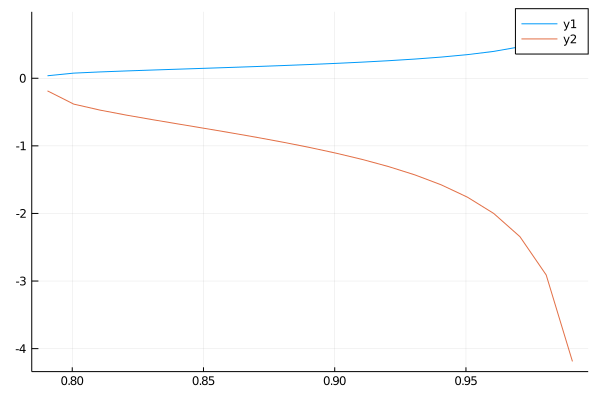

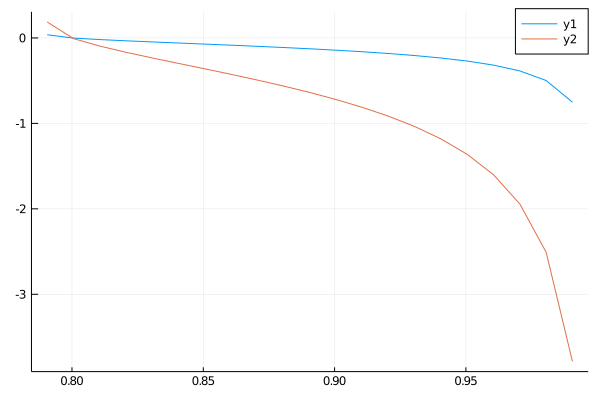

In [124]:
x = zgaps_pos[1,1]:.01:zgaps_pos[1,2]
y = map( z -> Φ(z,1)[1], x)
plot(x, y |> real)
plot!(x, y |> imag) |> display
y = map( z -> Φ(z,1)[2], x)
plot(x, y |> real)
plot!(x, y |> imag) |> display

In [125]:
map(x -> Φ(x,1), zs_z)

5-element Array{Transpose{Complex{Float64},Array{Complex{Float64},1}},1}:
 [0.35973325199760886 - 1.8104807888680312im -0.2809945413261994 - 1.4142012616931479im]
 [1.0043847421193823 - 0.7454307102450632im 0.4326391300469883 + 0.32109457707430905im]
 [0.9800827902375071 - 1.2303147396619103im -0.199586617393112 - 0.25054450467259154im]
 [1.0046242206542193 - 1.3445428684406686im -0.29104995829430136 - 0.3895278829034322im]
 [1.0444837424036215 - 0.6903844931189133im 0.3973763174268766 + 0.2626584180743364im]

In [33]:
k = 6
C1 = CauchyChop(map(x -> x.W,out[1]), map(x -> x.W,out[1][k:k]),n,n,1,1e-12);
v1 = BlockVector(vcat(map(x -> x.cs,out[1])...),n);
v2 = BlockVector(vcat(map(x -> x.cs,out[2])...),n);
v1[1]

20-element Array{Complex{Float64},1}:
      3.6933273366844803 + 3.729940102858182im
   0.0015534477749861286 + 0.0015688474444315766im
    6.596855513959318e-6 + 6.662251601183346e-6im
   3.7149984364812193e-8 + 3.7518265245745984e-8im
   2.363634674510689e-10 + 2.387119872085891e-10im
   1.547427914216514e-12 + 1.5580026930600718e-12im
  5.4590308408616234e-14 + 4.904866318285524e-14im
   -3.23665927943849e-14 - 3.446575929804311e-14im
   4.787368371389304e-14 + 4.923435698377734e-14im
 -4.3338308684112657e-14 - 4.006774685327663e-14im
  4.1611294227043016e-14 + 4.805661631001169e-14im
  -4.967578674378292e-14 - 4.6906255838202196e-14im
   5.340874767265326e-14 + 5.289283628599009e-14im
  -4.227263500134669e-14 - 4.917296559176413e-14im
   6.039074090170865e-14 + 5.2008751873424e-14im
  -5.410271115912429e-14 - 5.3152148734823596e-14im
  5.3133981140356845e-14 + 5.292655415058873e-14im
 -5.2547885103337045e-14 - 5.4699669599691466e-14im
  5.4947358251697455e-14 + 5.498542972586648e-1

In [34]:
y1 = (C1*v1).V .+ 1.0;
y2 = (C1*v2).V .+ 1.0;

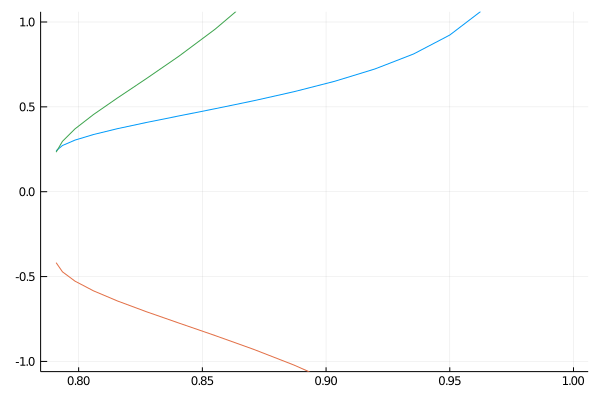

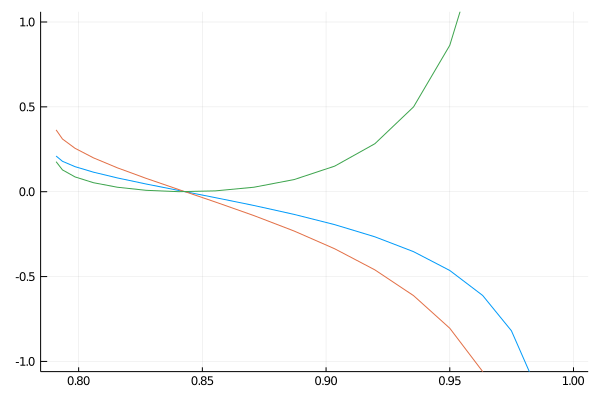

In [35]:
a = out[1][k].W.a
b = out[1][k].W.b
x = M(a,b)(Ugrid(n))
#x = Ugrid(n)
p = plot(x, y1 |> real)
plot!(x, y1 |> imag)
plot!(x, abs2.(y1), legend = false, yaxis = [-1,1]) |> display
p = plot(x, y2 |> real)
plot!(x, y2 |> imag)
plot!(x, abs2.(y2), legend = false, yaxis = [-1,1]) |> display

In [36]:
zs_z = sqrt.(zs)

5-element Array{Float64,1}:
 0.9529519813637036
 1.370728050247899
 1.7216426572492418
 1.995362407014846
 2.231281202973069

In [37]:
max_ind = (-1 .< real(rts) .< 1).*( abs.(imag(rts))  .<  1e-9)
rts[max_ind] |> display

UndefVarError: UndefVarError: rts not defined

In [39]:
kk = 5
a = out[1][kk].W.a
b = out[1][kk].W.b
computed_zs = map(x -> M(a,b)(x), rts[max_ind])[1]^2

UndefVarError: UndefVarError: rts not defined

In [40]:
Φ = (z,o) -> [Cauchy(out[1],z,o) + 1.0, Cauchy(out[2],z,o) + 1.0] |> transpose
Skew(abel[1])

2×2 Array{Complex{Float64},2}:
      0.0+0.0im       -0.50047+0.865754im
 -0.50047-0.865754im       0.0+0.0im

In [47]:
Φ(.8,1) - Φ(.8,-1)*Skew(abel[1])

1×2 Transpose{Complex{Float64},Array{Complex{Float64},1}}:
 1.18794e-14+1.66533e-15im  4.21885e-15-1.58207e-14im

In [42]:
Φ(.8,1) |> display
Φ(.8,-1) |> display

1×2 Transpose{Complex{Float64},Array{Complex{Float64},1}}:
 0.311414-0.539722im  0.140411+0.243352im

1×2 Transpose{Complex{Float64},Array{Complex{Float64},1}}:
 0.140411-0.243352im  0.311414+0.539722im

In [43]:

computed_zs - a^2 |> display
b^2 - computed_zs |> display
zs[1] - a^2 |> display
b^2 - zs[1] |> display

UndefVarError: UndefVarError: computed_zs not defined

In [44]:
g

5

In [45]:
function colleague_roots(x)  # I think this is wrong...
    cs = transformT(x)
    n = length(cs)-1
    cs[2:end] *= sqrt(2.0)
    A = Tridiagonal(fill(.5 |> complex,n-1),fill(0.0im,n),fill(.5 |> complex,n-1)) |> sparse
    A[1,:] -= .5*cs[1:end-1]/cs[end]
    A[end,end-1] = 1.0
    eigvals(Array(A))
end

colleague_roots (generic function with 1 method)